In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

import matplotlib.pyplot as plt


In [2]:

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        self.recurrent = DCRNN(node_features, 32, 1)
        self.linear = torch.nn.Linear(32, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h
        
model = RecurrentGCN(node_features = 4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()
    
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]

MSE: 1.0540


104
torch.Size([20])


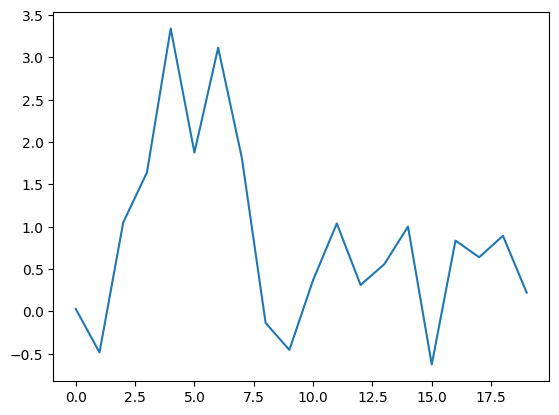

In [7]:
# Visualize the data set
test_dataset = list(test_dataset)
print(len(test_dataset))
print(test_dataset[0].y.shape)
plt.plot(test_dataset[0].y.cpu().numpy(), label='True')

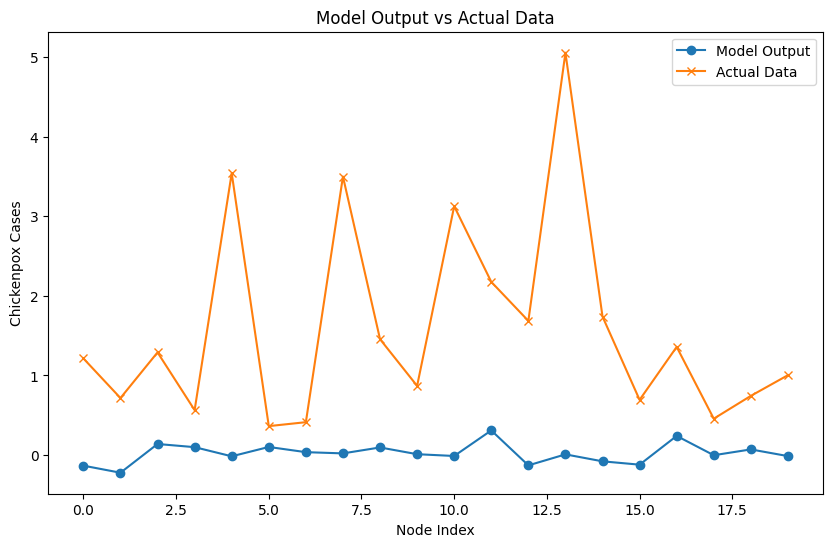

In [3]:
# Plot model output vs actual data for the last test snapshot
plt.figure(figsize=(10,6))
plt.plot(y_hat.detach().cpu().numpy(), label='Model Output', marker='o')
plt.plot(snapshot.y.detach().cpu().numpy(), label='Actual Data', marker='x')
plt.xlabel('Node Index')
plt.ylabel('Chickenpox Cases')
plt.title('Model Output vs Actual Data')
plt.legend()
plt.show()